# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

170498071/170498071 [==============================] - 14s 0us/step


This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the images directly to the model.
    - The two Conv2D layers below learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](https://github.com/devmehta01/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/conv_layer.png?raw=1)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](https://github.com/devmehta01/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/conv.png?raw=1)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="https://github.com/devmehta01/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/MaxpoolSample2.png?raw=1" width="600" hight="600" align="left"/>

In [3]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [4]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [5]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3
98/98 [==============================] - 12s 34ms/step - loss: 1.7903 - accuracy: 0.3521
Epoch 2/3
98/98 [==============================] - 3s 32ms/step - loss: 1.4396 - accuracy: 0.4852
Epoch 3/3
98/98 [==============================] - 3s 32ms/step - loss: 1.3241 - accuracy: 0.5291


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

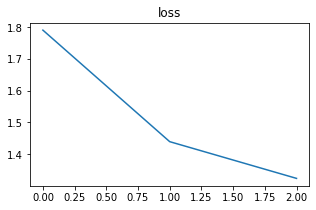

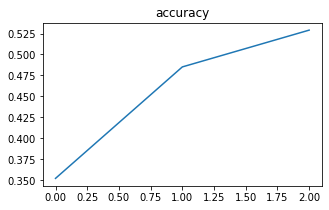

In [6]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 96.53%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). 

In [7]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 1.1619 - accuracy: 0.5882 - 1s/epoch - 3ms/step
accuracy: 58.82%
CPU times: user 1.23 s, sys: 145 ms, total: 1.37 s
Wall time: 1.25 s


We can also again check the confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 1s 2ms/step
[[704  35  41  17   8   9  22  16  94  54]
 [ 30 748   2   8   2   2  11  12  40 145]
 [108  16 364  66  79 115 125  72  26  29]
 [ 34  16  64 369  25 190 145  90  17  50]
 [ 49  11 104  71 320  43 212 171  11   8]
 [ 17  11  54 174  29 506  63 112  18  16]
 [ 12  19  32  57  24  19 770  34   7  26]
 [ 22   4  23  34  25  86  32 723   9  42]
 [154  73   9  10   3   9  11  11 667  53]
 [ 45 137   2   8   5   8  20  27  37 711]]

Classification accuracy for each class:

0: 0.7040
1: 0.7480
2: 0.3640
3: 0.3690
4: 0.3200
5: 0.5060
6: 0.7700
7: 0.7230
8: 0.6670
9: 0.7110


### More verbose training

This approach explicitly handles the looping over data. It will be helpful in future weeks for diving in and optimizing

In [9]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [10]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [11]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [12]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 3.2 seconds for epoch #0
beginning epoch 1
took 2.7 seconds for epoch #1
beginning epoch 2
took 2.7 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.06%, although it varies randomly.

In [14]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_2 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.2)
        self.conv_5 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_6 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_7 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_8 = tf.keras.layers.Dropout(0.2)
        self.conv_9 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_10 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_11 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_12 = tf.keras.layers.Dropout(0.2)
        self.dense_13 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_14 = tf.keras.layers.Dropout(0.2)
        self.dense_15 = tf.keras.layers.Dense(10, activation='softmax')
        

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        
        x = self.conv_5(x)
        x = self.conv_6(x)
        x = self.pool_7(x)
        x = self.drop_8(x)
        
        
        x = self.conv_9(x)
        x = self.conv_10(x)
        x = self.pool_11(x)
        x = self.drop_12(x)
        
        
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_13(x)
        x = self.drop_14(x)
        x = self.dense_15(x)

        return x

In [15]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [16]:
batch_size = 64
epochs = 20
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/20
782/782 [==============================] - 7s 8ms/step - loss: 1.6084 - accuracy: 0.4073
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 1.1334 - accuracy: 0.5950
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.9465 - accuracy: 0.6645
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.8206 - accuracy: 0.7134
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.7470 - accuracy: 0.7378
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6838 - accuracy: 0.7605
Epoch 7/20
782/782 [==============================] - 7s 8ms/step - loss: 0.6286 - accuracy: 0.7792
Epoch 8/20
782/782 [==============================] - 6s 8ms/step - loss: 0.5959 - accuracy: 0.7902
Epoch 9/20
782/782 [==============================] - 6s 8ms/step - loss: 0.5616 - accuracy: 0.8031
Epoch 10/20
782/782 [==============================] - 6s 8ms/step - loss: 0.5315 - accuracy: 0.8119

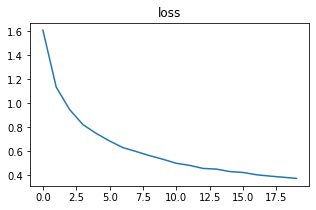

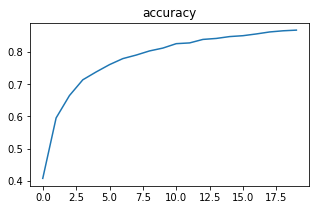

In [17]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [18]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 0.6497 - accuracy: 0.8084 - 1s/epoch - 4ms/step
accuracy: 80.84%
CPU times: user 1.52 s, sys: 58.7 ms, total: 1.58 s
Wall time: 1.65 s


In [19]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 2s 5ms/step
[[805  14  21   9  31   2  10  10  60  38]
 [  8 889   2   0   4   3   1   0  13  80]
 [ 63   4 656  24 112  55  44  22  10  10]
 [ 17   9  47 524 100 181  67  31  10  14]
 [  8   1  22  15 884  16  19  27   4   4]
 [ 10   2  18  71  65 769  19  35   3   8]
 [  5   3  22  19  48  13 874   6   7   3]
 [  9   1  12  17  55  35   4 848   1  18]
 [ 27  14   5   8   8   2   7   2 900  27]
 [  8  28   3   4   3   2   3   3  11 935]]

Classification accuracy for each class:

0: 0.8050
1: 0.8890
2: 0.6560
3: 0.5240
4: 0.8840
5: 0.7690
6: 0.8740
7: 0.8480
8: 0.9000
9: 0.9350
